# `politifact_scrap` dataset - Colab

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Loading `CSV` file from GCP Buket

In [15]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data shape: {data.shape}")
print('-'*80)
print('-'*80)
print(data['category'].value_counts()/len(data)*100)
print('-'*80)
print(data['category2'].value_counts()/len(data)*100)
print('-'*80)

--------------------------------------------------------------------------------
data shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [16]:
# data[data['text'].str.contains("Google Pinterest")]

In [17]:
data.head()

,author,statement,source,date,target,category_cat,category,category2
0,Emily Tian,“Washington public school forces unvaccinated ...,Facebook posts,"August 25, 2021",half-true,2.0,1,0
1,Samantha Putterman,75 doctors in South Florida walked out in prot...,Instagram posts,"August 25, 2021",false,4.0,1,1
2,Gabrielle Settles,"“It is the vaccinated, NOT the unvaccinated, s...",Facebook posts,"August 25, 2021",false,4.0,1,1
3,Tom Kertscher,“80% of women who have been jabbed have lost t...,Facebook posts,"August 24, 2021",false,4.0,1,1
4,Ciara O'Rourke,“Pfizer CEO has not yet had vaccine.”,Instagram posts,"August 24, 2021",false,4.0,1,1


### Preprocessing

In [18]:
hparams = {
    "clean_text": True,
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.0005,
    "max_num_words": 10000,
    "max_sequence_length": 30
}

In [19]:
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    """
    Provided by Le Wagon - Machine Learning - NLP
    Preprocessing articles - punctuation / lowercased / tokenize (not number) / stop_words / lemmatize
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

if hparams['clean_text']:
    X_text = data['statement'].apply(clean).copy()
    y = data['category2'].copy()
else:
    X_text = data['statement'].copy()
    y = data['category2'].copy()

print('-'*80)
print(f"X_text shape: {X_text.shape}")
print(f"y shape: {y.shape}")
print('-'*80)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
--------------------------------------------------------------------------------
X_text shape: (19826,)
y shape: (19826,)
--------------------------------------------------------------------------------


In [59]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_text_train shape: {X_text_train.shape}")
print(f"y_train shape: {y_train.shape}")
print('-'*80)
print(f"X_text_test shape: {X_text_test.shape}")
print(f"y_test shape: {y_test.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train shape: (15860,)
y_train shape: (15860,)
--------------------------------------------------------------------------------
X_text_test shape: (3966,)
y_test shape: (3966,)
--------------------------------------------------------------------------------


In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = hparams["max_num_words"])
tokenizer.fit_on_texts(X_text_train)

def prep_text(texts, tokenizer, **hparams):
    """
    Turns text into into padded sequences.
    """
    # kwargs.get("local", False)
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen = hparams["max_sequence_length"], padding='post')

X_text_train_pad = prep_text(X_text_train, tokenizer, **hparams)
X_text_test_pad = prep_text(X_text_test, tokenizer, **hparams)

print('-'*80)
print(f"X_text_train_pad shape: {X_text_train_pad.shape}")
print(f"X_text_test_pad shape: {X_text_test_pad.shape}")
print('-'*80)

text_vocab_size = len(tokenizer.word_index)
print('-'*80)
print(f"text vocab_size: {text_vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train_pad shape: (15860, 30)
X_text_test_pad shape: (3966, 30)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
text vocab_size: 12713
--------------------------------------------------------------------------------


## Model

In [14]:
import io
import urllib
import zipfile

def get_embedding(**hparams):
    """
    Pre-trained GloVe word vector embeddings
    """
    zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    zip_file = urllib.request.urlopen(zip_file_url)
    archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

    embeddings_index = {}
    glove_file = "glove.6B.100d.txt"

    with archive.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode("utf-8") 
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = get_embedding(**hparams)
print('-'*80)
print(f"embedding_matrix shape: {embedding_matrix.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix shape: (12714, 100)
--------------------------------------------------------------------------------


In [82]:
METRICS = [
    #   tf.keras.metrics.TruePositives(name='tp'),
    #   tf.keras.metrics.FalsePositives(name='fp'),
    #   tf.keras.metrics.TrueNegatives(name='tn'),
    #   tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

def init_model(metrics=METRICS, **hparams):
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = hparams["max_sequence_length"],
        trainable = hparams['embedding_trainable'],
        mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            filter_size, kernel_size, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=None))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)

    return model

In [50]:
def init_model2(metrics=METRICS, **hparams):
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_size = 10

    embedding_layer = tf.keras.layers.Embedding(
            input_dim = text_vocab_size+1,
            input_length = 20, # Max_sentence_length (optional, for model summary)
            output_dim = embedding_size,
            mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            # filter_size, kernel_size, activation='relu', padding='same', kernel_regularizer=None)
            filter_size, kernel_size, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=None))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)

    return model    
    
    
    model.add(tf.keras.layers.Embedding(
        input_dim = vocab_size+1,
        input_length = 1000, # Max_sentence_length (optional, for model summary)
#         input_length = X_train_pad.shape[1], # Max_sentence_length (optional, for model summary)
        output_dim = embedding_size,# 100
        mask_zero = True, # Included masking layer :)
    ))

In [63]:
init_model(**hparams).summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 30, 100)           1271400   
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 30, 128)           64128     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 6, 128)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 6, 128)            82048     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 1, 128)          

## Training on `text` input data

In [83]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=10, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

baseline_model = init_model(**hparams)

history = baseline_model.fit(X_text_train_pad, 
                  y_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
100/100 [==============================] - 2s 11ms/step - loss: 3.1050 - accuracy: 0.5898 - precision: 0.5923 - recall: 0.7815 - val_loss: 1.5676 - val_accuracy: 0.6330 - val_precision: 0.6467 - val_recall: 0.7229
Epoch 2/30
100/100 [==============================] - 1s 7ms/step - loss: 1.1439 - accuracy: 0.6399 - precision: 0.6579 - recall: 0.6999 - val_loss: 0.8843 - val_accuracy: 0.6381 - val_precision: 0.6387 - val_recall: 0.7766
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.7913 - accuracy: 0.6424 - precision: 0.6568 - recall: 0.7132 - val_loss: 0.7371 - val_accuracy: 0.6293 - val_precision: 0.6881 - val_recall: 0.5872
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.7037 - accuracy: 0.6538 - precision: 0.6760 - recall: 0.6945 - val_loss: 0.6966 - val_accuracy: 0.6305 - val_precision: 0.7062 - val_recall: 0.5537
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.6743 - accuracy: 0.6582 - p

In [84]:
def plot_loss(history, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')

    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('Recall')
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=1)
    ax3.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

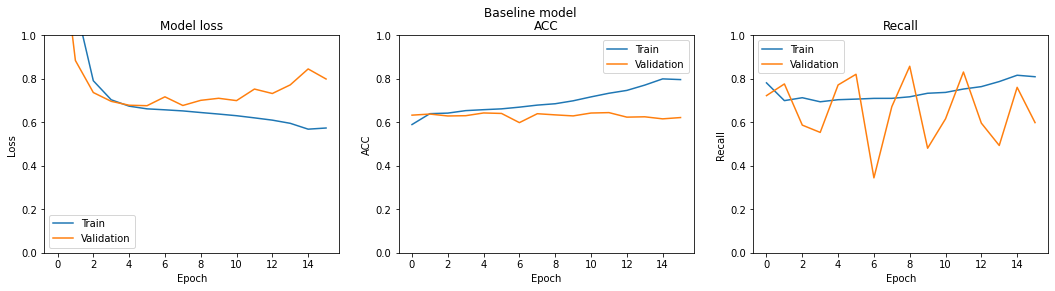

In [85]:
plot_loss(history, title='Baseline model')

--------------------------------------------------------------------------------
acc: 63.49%
recall: 81.87%
precision: 62.23%
f1: 70.71%
--------------------------------------------------------------------------------


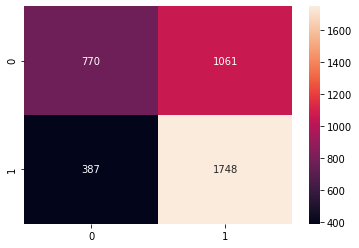

In [86]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def get_metrics(y_true, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

get_metrics(y_test, X_text_test_pad, baseline_model)

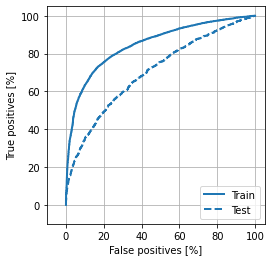

In [76]:
`def plot_roc(name, y_true, X, model, **kwargs):
    """
    Plot ROC curve
    """
    y_prob = model.predict(X)
    fp, tp, _ = roc_curve(y_true, y_prob)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-10, 105])
    plt.ylim([-10, 105])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_roc("Train", y_train, X_text_train_pad, baseline_model, color=colors[0])
plot_roc("Test", y_test, X_text_test_pad, baseline_model, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

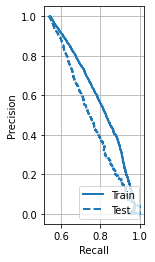

In [29]:
def plot_prc(name, y_true, X, model, **kwargs):
    """
    Plot AUPRC curve
    """
    y_prob = model.predict(X)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train", y_train, X_text_train_pad, baseline_model, color=colors[0])
plot_prc("Test", y_test, X_text_test_pad, baseline_model, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

## Training on `text` with `Class Weight`

In [146]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg = len(data[data['category']==0])
pos = len(data[data['category']==1])
total = len(data)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.76
Weight for class 1: 0.70


In [147]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=10, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

weighted_model = init_model2(**hparams)

weighted_history = weighted_model.fit(X_text_train_pad, 
                  y_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=40, 
                  callbacks=[es],
                  class_weight=class_weight,
                  verbose=1)

Epoch 1/40
87/87 [==============================] - 2s 12ms/step - loss: 2.7278 - accuracy: 0.6871 - precision: 0.7129 - recall: 0.9422 - val_loss: 1.5143 - val_accuracy: 0.7079 - val_precision: 0.7079 - val_recall: 1.0000
Epoch 2/40
87/87 [==============================] - 1s 8ms/step - loss: 1.1362 - accuracy: 0.7074 - precision: 0.7174 - recall: 0.9770 - val_loss: 0.9041 - val_accuracy: 0.7079 - val_precision: 0.7079 - val_recall: 1.0000
Epoch 3/40
87/87 [==============================] - 1s 8ms/step - loss: 0.8171 - accuracy: 0.6334 - precision: 0.7155 - recall: 0.8120 - val_loss: 0.7564 - val_accuracy: 0.7079 - val_precision: 0.7079 - val_recall: 1.0000
Epoch 4/40
87/87 [==============================] - 1s 8ms/step - loss: 0.7297 - accuracy: 0.7086 - precision: 0.7170 - recall: 0.9812 - val_loss: 0.7108 - val_accuracy: 0.7079 - val_precision: 0.7079 - val_recall: 1.0000
Epoch 5/40
87/87 [==============================] - 1s 8ms/step - loss: 0.7022 - accuracy: 0.6024 - precision: 

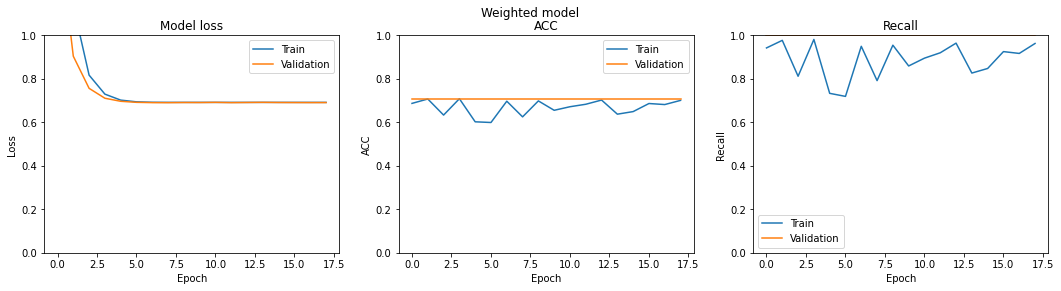

In [148]:
plot_loss(weighted_history, title='Weighted model')

--------------------------------------------------------------------------------
acc: 71.57%
recall: 100.00%
precision: 71.57%
f1: 83.43%
--------------------------------------------------------------------------------


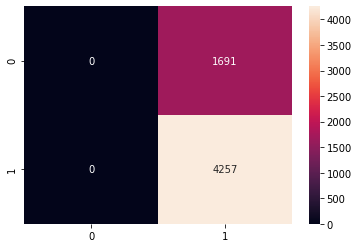

In [144]:
get_metrics(y_test, X_text_test_pad, weighted_model)

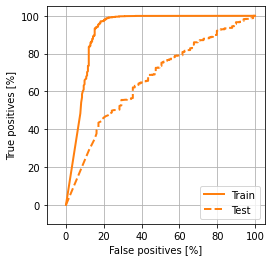

In [ ]:
plot_roc("Train", y_train, X_text_train_pad, weighted_model, color=colors[1])
plot_roc("Test", y_test, X_text_test_pad, weighted_model, color=colors[1], linestyle='--')
plt.legend(loc='lower right');

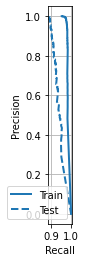

In [ ]:
plot_prc("Train", y_train, X_text_train_pad, weighted_model, color=colors[0])
plot_prc("Test", y_test, X_text_test_pad, weighted_model, color=colors[0], linestyle='--')
plt.legend(loc='lower right');